### **Importing Required Libraries**

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score , accuracy_score , classification_report
from sklearn.metrics import  precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from textblob import TextBlob
from scipy.sparse import hstack
import zipfile
import io
import os
import joblib
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### **Dataset Loading**

In [124]:
def explore_zip_contents(zip_file_path):
    # Opening the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Listing all contained files and directories
        name_list = zip_ref.namelist()

        # Filtering and exploring contents
        news_path_prefix = 'archive/News Articles/'
        categories = [name for name in name_list if name.count('/') == 3 and name.endswith('/')]

        category_names = [category[len(news_path_prefix):-1] for category in categories]
        print("Categories found:", category_names)

        return category_names

def read_and_preprocess(zip_file_path):
    # Dynamically extract categories from the ZIP file
    categories = explore_zip_contents(zip_file_path)

    texts = []  # Empty List to store text data and metadata

    with zipfile.ZipFile(zip_file_path, 'r') as z:
        for category in categories:
            # Constructing the path prefix for each category
            path_prefix = f'archive/News Articles/{category}/'
            # Filtering files for the current category
            file_names = [f for f in z.namelist() if f.startswith(path_prefix) and f.endswith('.txt')]

            for file in file_names:
                with z.open(file) as file_content:
                    try:
                        content = file_content.read().decode('utf-8')
                    except UnicodeDecodeError:
                        file_content.seek(0)
                        content = file_content.read().decode('latin-1')

                    texts.append({'Category': category, 'Filename': os.path.basename(file), 'Content': content})

    # Creating a DataFrame from the collected texts
    df = pd.DataFrame(texts)

    # Basic text cleaning
    df['Content'] = df['Content'].apply(lambda x: x.replace('\n', ' ').replace('\r', '').strip())

    return df

zip_file_path = 'archive.zip'
df_articles = read_and_preprocess(zip_file_path)
print(df_articles)


Categories found: ['business', 'entertainment', 'politics', 'sport', 'tech']
      Category Filename                                            Content
0     business  001.txt  Ad sales boost Time Warner profit  Quarterly p...
1     business  002.txt  Dollar gains on Greenspan speech  The dollar h...
2     business  003.txt  Yukos unit buyer faces loan claim  The owners ...
3     business  004.txt  High fuel prices hit BA's profits  British Air...
4     business  005.txt  Pernod takeover talk lifts Domecq  Shares in U...
...        ...      ...                                                ...
2220      tech  397.txt  BT program to beat dialler scams  BT is introd...
2221      tech  398.txt  Spam e-mails tempt net shoppers  Computer user...
2222      tech  399.txt  Be careful how you code  A new European direct...
2223      tech  400.txt  US cyber security chief resigns  The man makin...
2224      tech  401.txt  Losing yourself in online gaming  Online role ...

[2225 rows x 3 columns

### **Data Preprocessing**

In [125]:
def clean_text_with_category(content, category):
    # Converting content to lowercase
    content = content.lower()

    # Removing numbers and special characters
    content = re.sub(r'\d+', '', content)
    content = re.sub(r'\W+', ' ', content)

    # Tokenizing and removing stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in content.split() if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Reconstructing the cleaned text
    content_cleaned = ' '.join(words)

    return content_cleaned, category

# Applying the cleaning function
df_articles['Content_Cleaned'], df_articles['Category'] = zip(*df_articles.apply(lambda row: clean_text_with_category(row['Content'], row['Category']), axis=1))

print(df_articles[['Category', 'Content_Cleaned']])

      Category                                    Content_Cleaned
0     business  ad sale boost time warner profit quarterly pro...
1     business  dollar gain greenspan speech dollar hit highes...
2     business  yukos unit buyer face loan claim owner embattl...
3     business  high fuel price hit ba profit british airway b...
4     business  pernod takeover talk lift domecq share uk drin...
...        ...                                                ...
2220      tech  bt program beat dialler scam bt introducing tw...
2221      tech  spam e mail tempt net shopper computer user ac...
2222      tech  careful code new european directive could put ...
2223      tech  u cyber security chief resigns man making sure...
2224      tech  losing online gaming online role playing game ...

[2225 rows x 2 columns]


### **Data Visualization**

Step 1: Article Category Distribution

<ipython-input-126-6c8dde955039>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')


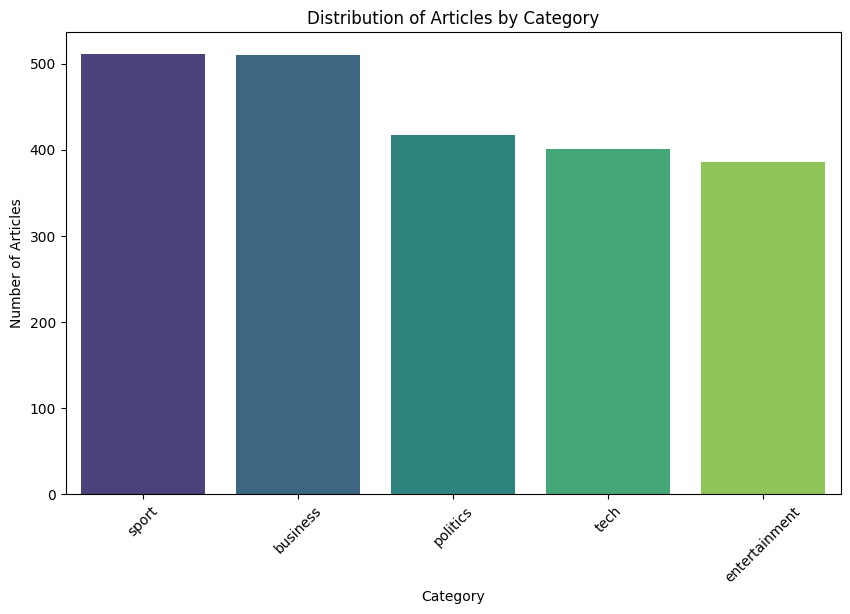

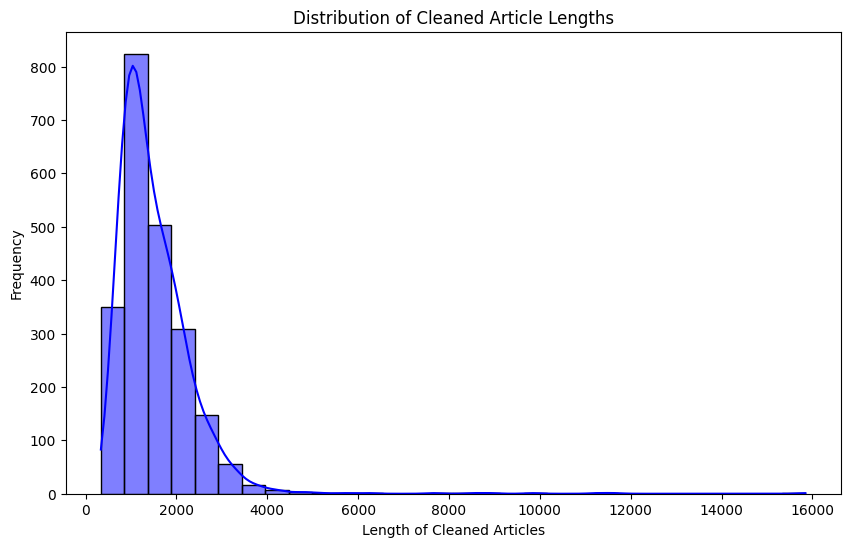

In [126]:
#Calculating the no of articles for each cateogry
category_counts = df_articles['Category'].value_counts()
# Calculating the length of each cleaned article
df_articles['Content_Length_Cleaned'] = df_articles['Content_Cleaned'].apply(len)

#Creating a bar plot to visualize the articles for each category
plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values, palette='viridis')
plt.title('Distribution of Articles by Category')
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

# Create a histogram  distribution visualization
plt.figure(figsize=(10, 6))
sns.histplot(df_articles['Content_Length_Cleaned'], bins=30, color='blue', kde=True)
plt.title('Distribution of Cleaned Article Lengths')
plt.xlabel('Length of Cleaned Articles')
plt.ylabel('Frequency')
plt.show()


### **Vectorization**

In [127]:
# Convert to numerical features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_articles['Content_Cleaned'])
y = df_articles['Category']

Advanced TF-IDF

In [128]:
def advanced_tfidf_features(data, max_features=2000, ngram_range=(1, 3)):
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(data['Content_Cleaned'])  # Using 'Content_Cleaned'
    return tfidf_matrix, vectorizer

# Applying the advanced TF-IDF vectorization
advanced_tfidf_matrix, advanced_vectorizer = advanced_tfidf_features(df_articles)
print("Shape of advanced TF-IDF Matrix:", advanced_tfidf_matrix.shape)

# Optional: Convert to DataFrame to see the actual features
advanced_tfidf_df = pd.DataFrame(advanced_tfidf_matrix.toarray(), columns=advanced_vectorizer.get_feature_names_out())

# Concatenate the Category column to the advanced TF-IDF DataFrame
advanced_tfidf_df_with_category = pd.concat([advanced_tfidf_df, df_articles['Category']], axis=1)
print(advanced_tfidf_df_with_category.head())


Shape of advanced TF-IDF Matrix: (2225, 2000)
   ability  able  absolutely  academy  accept  accepted  access  according  \
0      0.0   0.0         0.0      0.0     0.0       0.0     0.0        0.0   
1      0.0   0.0         0.0      0.0     0.0       0.0     0.0        0.0   
2      0.0   0.0         0.0      0.0     0.0       0.0     0.0        0.0   
3      0.0   0.0         0.0      0.0     0.0       0.0     0.0        0.0   
4      0.0   0.0         0.0      0.0     0.0       0.0     0.0        0.0   

    account  accounting  ...  year said  yen      york  young  young people  \
0  0.098367         0.0  ...        0.0  0.0  0.000000    0.0           0.0   
1  0.149970         0.0  ...        0.0  0.0  0.102106    0.0           0.0   
2  0.000000         0.0  ...        0.0  0.0  0.000000    0.0           0.0   
3  0.000000         0.0  ...        0.0  0.0  0.000000    0.0           0.0   
4  0.000000         0.0  ...        0.0  0.0  0.000000    0.0           0.0   

   younger

### **Splitting data for Training and Testing**

In [129]:
X = advanced_tfidf_matrix
y = df_articles['Category']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training Set Shapes:", X_train.shape, y_train.shape)
print("Testing Set Shapes:", X_test.shape, y_test.shape)

Training Set Shapes: (1780, 2000) (1780,)
Testing Set Shapes: (445, 2000) (445,)


**Logistic Regression**

Logistic Regression scores
Accuracy: 0.9662921348314607
Precision: 0.9668082652978116
Recall: 0.9662921348314607
F1 Score: 0.9664064254417953

Logistic regression Classification Report:
                precision    recall  f1-score   support

     business       0.94      0.96      0.95       115
entertainment       0.99      0.96      0.97        72
     politics       0.94      0.97      0.95        76
        sport       1.00      0.99      1.00       102
         tech       0.97      0.95      0.96        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



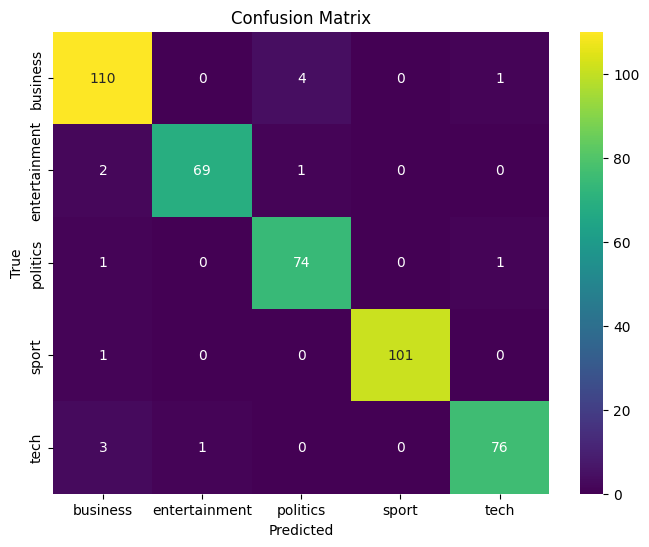

In [130]:
# Training the logistic regression model
log_reg = LogisticRegression(max_iter=1000, penalty='l2', C=1.0, multi_class='multinomial', solver='lbfgs', random_state=42)
log_reg.fit(X_train, y_train)

# Making predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # 'weighted' handles class imbalance
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Printing evaluation metrics
print("Logistic Regression scores")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification Report
print("\nLogistic regression Classification Report:\n", classification_report(y_test, y_pred))

# Displaying the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='viridis', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


ROC Curve for Logistic Regression

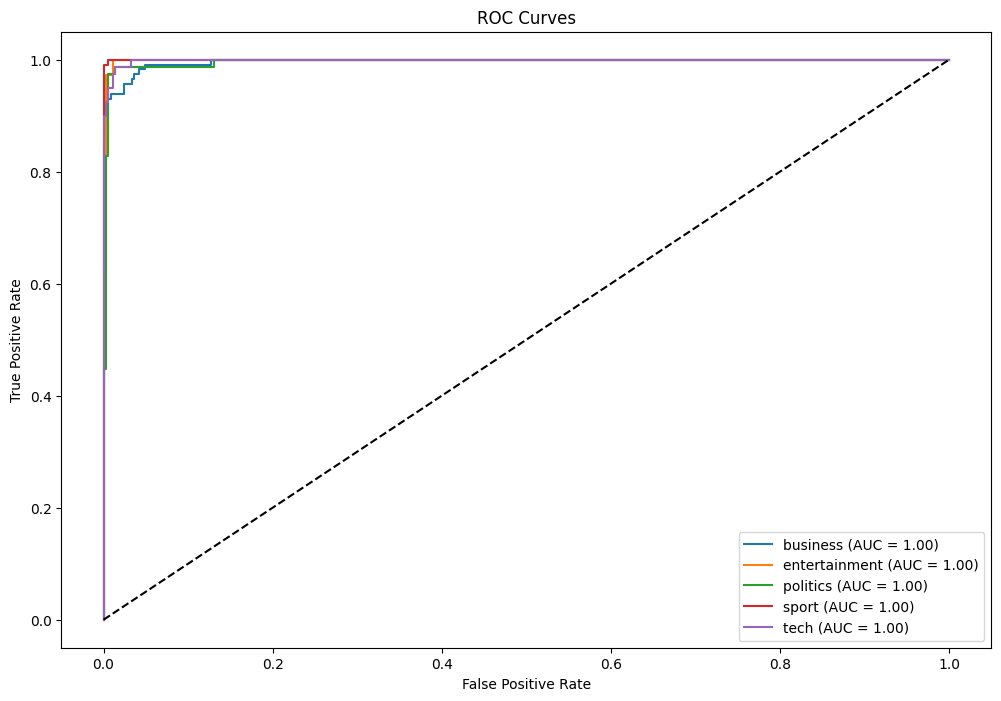

In [131]:
y_proba_logistic = log_reg.predict_proba(X_test)  # For ROC curve

# ROC Curves
plt.figure(figsize=(12, 8))

# Generating ROC curves for each class
unique_labels = np.unique(y_test)

for i, label in enumerate(unique_labels):
    fpr, tpr, _ = roc_curve((y_test == label).astype(int), y_proba_logistic[:, i])
    auc = roc_auc_score((y_test == label).astype(int), y_proba_logistic[:, i])

    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('ROC Curves')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


1) Comparing the performance metrics on the training set with those on the testing set

In [132]:
# Making predictions on the training set
y_train_pred = log_reg.predict(X_train)

# Evaluation on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
#Printing evaluation metrics for training set
print("Training Set Performance:")
print("Accuracy:", train_accuracy)
print("Precision:", train_precision)
print("Recall:", train_recall)
print("F1 Score:", train_f1)

# Evaluation on the test set
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')
test_f1 = f1_score(y_test, y_pred, average='weighted')
#Printing evaluation metrics for testing set
print("\nTesting Set Performance:")
print("Accuracy:", test_accuracy)
print("Precision:", test_precision)
print("Recall:", test_recall)
print("F1 Score:", test_f1)


Training Set Performance:
Accuracy: 0.9938202247191011
Precision: 0.9938363621436136
Recall: 0.9938202247191011
F1 Score: 0.9938226082136918

Testing Set Performance:
Accuracy: 0.9662921348314607
Precision: 0.9668082652978116
Recall: 0.9662921348314607
F1 Score: 0.9664064254417953


2) Cross validation for Logisitic Regression

In [133]:
# Creating a logistic regression model with cross validation to prevent overfitting
log_reg = LogisticRegression(max_iter=1000, penalty='l2', C=1.0, multi_class='multinomial', solver='lbfgs', random_state=42)

# Performing k-fold cross-validation with k=5
k = 5
cv_scores = cross_val_score(log_reg, X, y, cv=k, scoring='accuracy')

#Printing the cross-validation results
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation of CV Scores: {cv_scores.std():.4f}")


Cross-Validation Scores: [0.94831461 0.96404494 0.93033708 0.98202247 0.98426966]
Mean Cross-Validation Score: 0.9618
Standard Deviation of CV Scores: 0.0204


* The slight drop in performance from the training set to the testing set (from 99.38% to 96.63% accuracy) is normal and expected. This indicates that the model is not significantly overfitting.
* The cross-validation mean score (96.18%) is close to the test set performance, providing additional evidence that the model is not overfitting

Re-Training on Full Training Data and Evaluating on a Test Set

In [134]:
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9662921348314607
Classification Report:
                precision    recall  f1-score   support

     business       0.94      0.96      0.95       115
entertainment       0.99      0.96      0.97        72
     politics       0.94      0.97      0.95        76
        sport       1.00      0.99      1.00       102
         tech       0.97      0.95      0.96        80

     accuracy                           0.97       445
    macro avg       0.97      0.97      0.97       445
 weighted avg       0.97      0.97      0.97       445



### **Saving the model**

In [135]:
joblib.dump(log_reg, 'logistic_regression.pkl')

['logistic_regression.pkl']

In [136]:
joblib.dump(advanced_vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

### **Categorizing Unseen Data:**

Using the pre-trained Logistic Regression model to classify 15 sample articles. This step assesses whether the model has learned effectively during training and helps identify any signs of overfitting. It serves as a practical application of the model and provides a final validation check.

In [137]:
# Preprocessing function
def preprocess_text(content):
    # Convert content to lowercase
    content = content.lower()

    # Removing numbers and special characters
    content = re.sub(r'\d+', '', content)
    content = re.sub(r'\W+', ' ', content)

    # Tokenizing and remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in content.split() if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Reconstruct the cleaned text
    return ' '.join(words)

# Loading the pretrained Logistic model
log_reg = joblib.load('logistic_regression.pkl')

# Loading the vectorizer used during training
advanced_vectorizer = joblib.load('vectorizer.pkl')


sample_articles = [
    """
    Recent developments in artificial intelligence (AI) have accelerated progress across the tech industry. Innovations in neural network architectures and machine learning algorithms have led to faster data processing, enabling real-time analytics and automation. These advancements have spurred growth in diverse sectors, including e-commerce, healthcare, and autonomous vehicles, further integrating technology into daily life.
    """,
    """
    The national football team secured a dramatic win in yesterday's match, advancing to the finals. The game saw several key plays, with the team's captain scoring a decisive goal in the final minutes. Fans and analysts alike are celebrating the team's achievement, marking a significant step forward in the tournament. The coach praised the players for their dedication and teamwork, emphasizing the importance of unity in their path to victory. The team now prepares for the upcoming finals, aiming to clinch the championship title.
    """,
    """
    The government's recent policy has led to a significant reduction in taxes for small businesses, providing a much-needed boost to the economy. This initiative aims to stimulate growth and create new job opportunities. Analysts predict a positive impact, particularly in sectors like technology and retail. The plan also includes grants and other incentives to support entrepreneurship, encouraging new startups and fostering innovation. Small business owners have expressed optimism, with some planning to expand their operations in light of the favorable economic climate.
    """,
    """
    The recent election has sparked significant debate, with candidates from various parties presenting their visions for the country's future. Key topics include healthcare reform, economic growth, and environmental policies. In a heated debate, candidates outlined their strategies for tackling these issues, with some proposing changes to the current system. Public opinion is divided, and many are eagerly awaiting the outcome. Political analysts suggest that voter turnout will play a crucial role in determining the election's result, emphasizing the need for civic engagement.
    """,
    """
    The highly anticipated film "The Digital Frontier" premiered last night to critical acclaim. The movie explores the impact of technology on modern society, delving into themes of innovation, connectivity, and social change. Critics praised the film's engaging narrative and compelling characters, with many highlighting its thought-provoking message. The movie's director, Jane Smith, expressed excitement over the positive reception, noting the importance of sparking conversations about technology's role in our daily lives.
    """,
    """
    A new quantum computing advancement has emerged, promising to revolutionize data processing. Researchers have developed a qubit system capable of performing calculations exponentially faster than classical methods. The breakthrough paves the way for complex simulations in science, finance, and cryptography, potentially unlocking new opportunities for innovation.
    """,
    """
    In a thrilling final match, tennis star John Doe secured another championship title. The game showcased intense rallies and strategic plays, with Doe clinching the win in the final set. Fans celebrated the victory, marking Doe's fourth title this season. The champion attributed the success to rigorous training and focus, emphasizing the importance of perseverance.
    """,
    """
    The government has announced a new healthcare policy aimed at expanding access to medical services. The plan includes funding for community health centers and subsidies for lower-income individuals. Political analysts expect heated debate over its implementation, with proponents emphasizing its potential to improve public health outcomes.
    """,
    """
    The sequel to last year's blockbuster has smashed box office records in its opening weekend. The film, "Galactic Empire II," drew audiences with its high-octane action and special effects. Critics praised its thrilling plot twists and character development. The movie's director hinted at a third installment, exciting fans worldwide.
    """,
    """
    A new report indicates a surge in startup funding, particularly in tech and e-commerce sectors. Venture capital investments have reached record levels, with companies like FinTech Innovations securing millions. Analysts attribute the growth to favorable economic conditions and increased consumer demand, projecting continued expansion.
    """,
    """
    The smart home market continues to expand, with new devices offering innovative solutions for households. Products like smart thermostats and voice-controlled assistants have become increasingly popular, integrating technology seamlessly into daily life. Industry experts foresee rapid growth in this sector, driven by convenience and automation trends.
    """,
    """
    The Olympic trials have begun, with athletes from across the nation competing for spots on the team. The swimming events showcased impressive performances, with several competitors breaking national records. Coaches and spectators anticipate intense competition in the coming days, as athletes strive to represent their country on the global stage.
    """,
    """
    A new legislative bill seeks to increase investment in renewable energy projects. The proposal includes tax incentives for solar and wind companies, aiming to reduce carbon emissions and promote sustainable practices. Environmental groups have praised the initiative, while critics question its feasibility, sparking debate on its potential impact.
    """,
    """
    The lineup for this year's Music Fest has been revealed, featuring top artists from various genres. Headliners include rock band Thunderstrike and pop sensation Ella Blue. Fans are eagerly anticipating the event, set to take place next month, promising a weekend of live performances and entertainment.
    """,
    """
    A major retail chain has announced plans for an aggressive expansion, opening 50 new stores across the country. The move aims to increase market share and reach new consumers. Analysts see the expansion as a strategic effort to stay competitive, particularly against e-commerce rivals. The company expects the new stores to create thousands of jobs.
    """
]

# Preprocessing and classifying each sample
for i, article in enumerate(sample_articles):
    # Preprocessing the article
    processed_text = preprocess_text(article)
    # Vectorizing the text
    X_sample = advanced_vectorizer.transform([processed_text])
    # Predicting the category
    predicted_category = log_reg.predict(X_sample)[0]

    print(f"Sample {i+1} falls under the '{predicted_category}' category.")

Sample 1 falls under the 'tech' category.
Sample 2 falls under the 'sport' category.
Sample 3 falls under the 'business' category.
Sample 4 falls under the 'politics' category.
Sample 5 falls under the 'entertainment' category.
Sample 6 falls under the 'tech' category.
Sample 7 falls under the 'sport' category.
Sample 8 falls under the 'politics' category.
Sample 9 falls under the 'entertainment' category.
Sample 10 falls under the 'business' category.
Sample 11 falls under the 'tech' category.
Sample 12 falls under the 'sport' category.
Sample 13 falls under the 'business' category.
Sample 14 falls under the 'entertainment' category.
Sample 15 falls under the 'business' category.


Overall, the model is well-trained and accurately identifies the categories of sample articles, confirming that the reported accuracy values are reliable and reflective of the model's performance.